### Analysis Version 3 (a version that actually works)
##### Highlights from model, state-by-state analysis, and aggregate review.

Following the results of the updated optimisation model, this notebook aims to shed light on the outcomes. In general, it seeks to answer the question *'how can biofuels complement electrification?'* at a county level, across the set of chosen states (MN, TX, CA).

Between model v0.1 and model v0.2, the following changes were made:
- Solutions involve running linear regression in order to better understand county-level factors allowing 
- Adding at-home charging to EV viability index



In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.float_format', '{:.2f}'.format)
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = None

In [1]:
selected_states = ['CA','TX','MN']
vdf = pd.read_csv('optimisation_data/visual_df.csv')
del vdf['Unnamed: 0']

In [2]:
vdf['annual_ghg_emissions'].mean()

517635153431.1283

In [3]:
ca_vdf = vdf[vdf['State']=='CA']
tx_vdf = vdf[vdf['State']=='TX']
mn_vdf = vdf[vdf['State']=='MN']
a = pd.Series(vdf.mean(), name='overall_mean')
b = pd.Series(ca_vdf.mean(), name='mn_mean')
c = pd.Series(tx_vdf.mean(), name='tx_mean')
d = pd.Series(mn_vdf.mean(), name='ca_mean')
pd.DataFrame([a,b,c,d]).T

,overall_mean,mn_mean,tx_mean,ca_mean
annual_ghg_emissions,517635153431.13,1504047633371.00,344394757320.12,365809139358.53
annual_operating_cost,38627995.46,141759569.40,17803700.53,30670979.63
total_annual_cost,925276379.49,3014419829.51,579481613.34,542075810.53
annual_fuel_use,19275618.07,60394190.47,11521753.83,14500955.04
total_vehicle_count,154795.45,507595.84,98121.35,85057.48
vehicle_split_BEV,140634.06,500653.83,84171.86,65464.52
vehicle_split_FFV,2137.25,1385.70,1207.36,5353.14
vehicle_split_SIDI,12024.14,5556.31,12742.13,14239.82
vehicle_pc_BEV,48.32,82.30,43.81,38.84
vehicle_pc_FFV,4.19,0.17,0.93,16.40


In [4]:
evi = pd.read_csv('efuels_vi.csv')
del evi['Unnamed: 0']
evi.columns

Index(['GEO_ID', 'STATE', 'COUNTY', 'NAME', 'LSAD', 'CENSUSAREA', 'geometry',
       'electric fuel station', 'efuels_area'],
      dtype='object')

In [5]:
evi.NAME = evi.NAME.str.replace('_',' ')
evi = evi[['NAME','efuels_area','CENSUSAREA']]
vdf = vdf.merge(evi, left_on='County',right_on='NAME')
vdf.rename(columns={'CENSUSAREA':'census_area'}, inplace=True)
vdf.drop('NAME', axis=1,inplace=True)

In [6]:
vdf.dtypes

County                    object
annual_ghg_emissions     float64
annual_operating_cost    float64
total_annual_cost        float64
annual_fuel_use          float64
total_vehicle_count      float64
vehicle_split_BEV        float64
vehicle_split_FFV        float64
vehicle_split_SIDI       float64
vehicle_pc_BEV           float64
vehicle_pc_FFV           float64
vehicle_pc_SIDI          float64
State                     object
efuels_area              float64
census_area              float64
dtype: object

In [7]:
ru = pd.read_csv('preprocessed_data/rural_urban.csv')
del ru['Note']
ru = ru[ru.State.isin(selected_states)]
ru.rename(columns = {'2015 Geography Name':'County','2010 Census \nPercent Rural' : 'pct_rural',
                    '2010 Census Total Population':'census_totpop', '2010 Census Rural Population':'census_rurpop',
                    '2010 Census Urban Population':'census_urbpop'},inplace=True)

ru.County = ru.County.str.replace(' County, Texas','')
ru.County = ru.County.str.replace(' County, California','')
ru.County = ru.County.str.replace(' County, Minnesota','')

In [8]:
#cleaning up the document here to ensure that we have the right names
repeated_list = ['Orange','Cass','Lake','Trinity','Houston','Polk','Brown','Clay','Jackson','Washington','Martin']
ru.loc[ru['County'].isin(repeated_list), 'County'] = ru['County'] + ' ' + ru['State']
vdf = vdf.merge(ru)
#checking if the sets are the same
misfits = set(ru.County).symmetric_difference(set(vdf.County))
len(misfits)

0

In [9]:
vdf['census_totpop'] = vdf['census_totpop'].apply(lambda x: x.replace(',','')).astype(int)
vdf['census_urbpop'] = vdf['census_urbpop'].apply(lambda x: x.replace(',','')).astype(int)
vdf['census_rurpop'] = vdf['census_rurpop'].apply(lambda x: x.replace(',','')).astype(int)
vdf['pop_density'] =vdf['census_totpop']/vdf['census_area']
trunc = lambda x: math.trunc(1000 * x) / 1000
vdf['census_area'] = vdf['census_area'].apply(trunc)

vdf.loc[vdf['pop_density'] >= 750, 'county_class'] = 'urban'
vdf.loc[vdf['pop_density'] <= 750, 'county_class'] = 'suburban'
vdf.loc[vdf['pct_rural'] >= 50, 'county_class'] = 'rural'

In [10]:
vdf.loc[vdf['county_class'] == 'suburban','efuels_area'] = vdf['efuels_area']+40
vdf.loc[vdf['county_class'] == 'urban','efuels_area'] = vdf['efuels_area']+25

vdf['efuels_area'] = vdf['efuels_area'].apply(lambda x: 100 if x >= 100 else x)
vdf['efuels_area'].describe()

count   399.00
mean     33.51
std      32.37
min       0.00
25%       0.00
50%      36.77
75%      55.62
max     100.00
Name: efuels_area, dtype: float64

In [11]:
vdf['vehicle_pc_SIDI'].mean()

47.488972431077734

In [12]:
vdf['census_rurpop'].corr(vdf['efuels_area'])

0.41042060639905903

In [13]:
vdf['efuels_area'].corr(vdf['census_rurpop'])

0.410420606399059

In [14]:
vdf.sort_values(by='pop_density',ascending=False).head()[['County','census_area','efuels_area','census_totpop','census_urbpop','census_rurpop','pct_rural','pop_density']]

,County,census_area,efuels_area,census_totpop,census_urbpop,census_rurpop,pct_rural,pop_density
37,San Francisco,46.87,100.00,805235,805235,0,0.00,17179.08
29,Orange CA,790.57,100.00,3010232,3005917,4315,0.10,3807.68
119,Ramsey,152.21,100.00,508640,507688,952,0.20,3341.66
201,Dallas,871.28,100.00,2368139,2351839,16300,0.70,2718.00
18,Los Angeles,4057.88,87.97,9818605,9759181,59424,0.60,2419.64


In [15]:
from sklearn.linear_model import LinearRegression
X = vdf['efuels_area'].values.reshape(-1, 1)  # values converts it into a numpy array
y = vdf['pop_density'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column

In [16]:
X.mean()

33.51434334951582

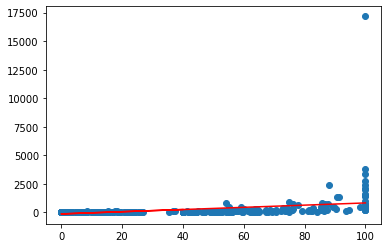

In [17]:
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, y)  # perform linear regression
y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.show()

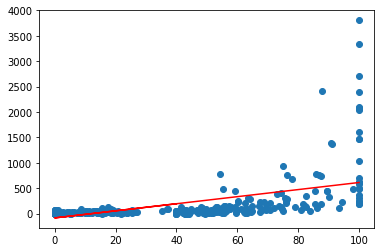

In [18]:
X_new = vdf[vdf.County != 'San Francisco']['efuels_area'].values.reshape(-1,1)
y_new = vdf[vdf.County != 'San Francisco']['pop_density'].values.reshape(-1,1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X_new, y_new)  # perform linear regression
y_newpred = linear_regressor.predict(X_new)  # make predictions
plt.scatter(X_new, y_new)
plt.plot(X_new, y_newpred, color='red')
plt.show()

#### Overall results:

In [19]:
vdf[['State','vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI','efuels_area']].groupby(by='State').mean()

,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI,efuels_area
State,,,,
CA,82.30,0.17,17.53,65.46
MN,38.84,16.40,44.76,28.97
TX,43.81,0.93,55.27,27.78


#### Real Analysis: California

In [62]:
# vdf[vdf['State']=='CA'].sort_values(by='efuels_area',ascending=True).head()
# vdf[(vdf['State']=='TX') & (vdf['vehicle_pc_FFV']>vdf['vehicle_pc_BEV'])].sort_values(by='vehicle_pc_FFV',ascending=False)
vdf[(vdf['State']=='MN') & (vdf['vehicle_pc_FFV']>0)].sort_values(by='vehicle_pc_FFV',ascending=False)

,County,annual_ghg_emissions,annual_operating_cost,total_annual_cost,annual_fuel_use,total_vehicle_count,vehicle_split_BEV,vehicle_split_FFV,vehicle_split_SIDI,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI,State,efuels_area,census_area,census_totpop,census_urbpop,census_rurpop,pct_rural,pop_density,county_class,ghg_globalrank,popden_globalrank,censusarea_globalrank,ghg_staterank,popden_staterank,censusarea_staterank
138,Waseca,118811080000.00,12959585.50,187710128.00,8960031.00,26698.00,0.00,18181.09,8516.91,0.00,68.10,31.90,MN,0.00,423.36,19136,9537,9599,50.20,45.20,rural,175.00,148.00,377.00,46.00,30.00,80.00
100,McLeod,179260932000.00,23210085.70,352516360.00,15709924.20,51135.00,7791.25,33559.10,9784.65,15.20,65.60,19.10,MN,68.09,491.47,36651,19588,17063,46.60,74.57,suburban,133.00,104.00,362.00,32.00,19.00,69.00
74,Cottonwood,60027191000.00,7994397.30,114724579.00,5434810.40,16306.00,0.00,10135.02,6170.98,0.00,62.20,37.80,MN,0.00,638.61,11687,4409,7278,62.30,18.30,rural,244.00,246.00,323.00,67.00,57.00,47.00
144,Yellow Medicine,53904179100.00,7100187.86,102226657.20,4792604.15,14563.00,281.56,8778.78,5502.66,1.90,60.30,37.80,MN,1.93,759.10,10438,2002,8436,80.80,13.75,rural,257.00,272.00,285.00,70.00,67.00,31.00
70,Chisago,262738283000.00,29027294.60,499582700.00,18584589.00,75183.00,31120.72,44062.29,0.00,41.40,58.60,0.00,MN,41.39,414.86,53887,23932,29955,55.60,129.89,rural,101.00,73.00,380.00,19.00,11.00,82.00
97,Le Sueur,142842975000.00,17362337.30,264758822.00,11338910.00,38651.00,8074.76,21699.13,8877.11,20.90,56.10,23.00,MN,20.89,448.76,27703,10483,17220,62.20,61.73,rural,155.00,121.00,367.00,40.00,22.00,72.00
89,Jackson MN,51676333000.00,7094753.80,100845299.00,4739442.50,14323.00,0.00,8014.81,6308.19,0.00,56.00,44.00,MN,0.00,702.98,10266,3169,7097,69.10,14.60,rural,265.00,266.00,308.00,72.00,65.00,43.00
122,Renville,83133503000.00,10104880.40,151224580.00,6587460.35,21946.00,3648.81,11824.83,6472.37,16.60,53.90,29.50,MN,16.63,982.91,15730,0,15730,100.00,16.00,rural,218.00,257.00,143.00,60.00,64.00,22.00
121,Redwood,87452795000.00,10409496.80,154731846.00,6784123.84,22405.00,3362.48,11907.55,7134.97,15.00,53.10,31.80,MN,15.01,878.57,16059,4958,11101,69.10,18.28,rural,213.00,247.00,241.00,58.00,58.00,25.00
87,Isanti,235166544000.00,22102602.20,353794725.00,13764377.40,52761.00,19714.56,25766.96,7279.48,37.40,48.80,13.80,MN,37.37,435.79,37816,14270,23546,62.30,86.77,rural,107.00,95.00,372.00,21.00,15.00,75.00


In [57]:
# vdf[(vdf['State']=='TX')].sort_values(by='annual_ghg_emissions',ascending=False).head(30)
# vdf[(vdf['State']=='CA')].sort_values(by='pop_density',ascending=False)

In [22]:
vdf[(vdf['State']=='TX') & (vdf['vehicle_pc_BEV']==0) & (vdf['vehicle_pc_FFV']>0)].sort_values(by='vehicle_pc_FFV',ascending=False)
# vdf[(vdf['State']=='CA') & (vdf['vehicle_pc_BEV']>0)].sort_values(by='vehicle_pc_FFV',ascending=False).mean()
# vdf[(vdf['State']=='TX') & (vdf['County']=='Harris')].sort_values(by='vehicle_pc_FFV',ascending=False)

,County,annual_ghg_emissions,annual_operating_cost,total_annual_cost,annual_fuel_use,total_vehicle_count,vehicle_split_BEV,vehicle_split_FFV,vehicle_split_SIDI,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI,State,efuels_area,census_area,census_totpop,census_urbpop,census_rurpop,pct_rural,pop_density,county_class
151,Atascosa,291744672500.00,23595841.00,355319474.00,18171949.20,50680.00,0.00,4936.30,45743.70,0.00,9.70,90.30,TX,0.00,1219.54,44911,17645,27266,60.70,36.83,rural
331,Polk TX,330729548400.00,26663853.40,398877667.00,20509589.40,56866.00,0.00,4801.87,52064.13,0.00,8.40,91.60,TX,0.00,1057.09,45413,10155,35258,77.60,42.96,rural
307,Medina,143992358200.00,27755904.87,399910818.20,21203955.66,56857.00,0.00,501.54,56355.46,0.00,0.90,99.10,TX,0.00,1325.36,46006,17687,28319,61.60,34.71,rural


In [23]:
interested_counties_ca = ['San Francisco','Los Angeles','San Bernardino'] 
interested_counties_mn = ['Ramsey','Hennepin','St. Louis']
interested_counties_tx = ['Bexar','Dallas','Comal','Lubbock','Travis']

In [24]:
#global ranking (across the sample)
vdf['ghg_globalrank'] = vdf['annual_ghg_emissions'].rank(ascending=False)
vdf['popden_globalrank'] = vdf['pop_density'].rank(ascending=False)
vdf['censusarea_globalrank'] = vdf['census_area'].rank(ascending=False)

#state ranking (within state)
vdf['ghg_staterank'] = vdf.groupby('State')['annual_ghg_emissions'].rank('dense', ascending=False)
vdf['popden_staterank'] = vdf.groupby('State')['pop_density'].rank('dense', ascending=False)
vdf['censusarea_staterank'] = vdf.groupby('State')['census_area'].rank('dense', ascending=False)

In [25]:
vdf.to_feather('analysed_vdf')

In [26]:
# vdf[vdf['County']].isin(['San Francisco','Los Angeles','San Bernadino'])
vdf[vdf['County'].isin(interested_counties_ca)][['County','State','vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI','ghg_globalrank','ghg_staterank','popden_globalrank','popden_staterank','censusarea_globalrank','censusarea_staterank']]

,County,State,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI,ghg_globalrank,ghg_staterank,popden_globalrank,popden_staterank,censusarea_globalrank,censusarea_staterank
18,Los Angeles,CA,100.00,0.00,0.00,2.00,1.00,5.00,3.00,15.00,11.00
35,San Bernardino,CA,89.90,4.30,5.90,8.00,4.00,88.00,32.00,1.00,1.00
37,San Francisco,CA,100.00,0.00,0.00,33.00,16.00,1.00,1.00,399.00,58.00


In [27]:
vdf[vdf['County'].isin(interested_counties_mn)][['County','State','vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI','ghg_globalrank','ghg_staterank','popden_globalrank','popden_staterank','censusarea_globalrank','censusarea_staterank']]


,County,State,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI,ghg_globalrank,ghg_staterank,popden_globalrank,popden_staterank,censusarea_globalrank,censusarea_staterank
84,Hennepin,MN,100.00,0.00,0.00,6.00,1.00,8.00,2.00,348.00,60.00
119,Ramsey,MN,100.00,0.00,0.00,15.00,2.00,3.00,1.00,397.00,87.00
126,St. Louis,MN,2.90,3.60,93.50,35.00,6.00,184.00,38.00,6.00,1.00


In [28]:
vdf[vdf['County'].isin(interested_counties_tx)][['County','State','ghg_globalrank','ghg_staterank','popden_globalrank','popden_staterank','censusarea_globalrank','censusarea_staterank','vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI']]

,County,State,ghg_globalrank,ghg_staterank,popden_globalrank,popden_staterank,censusarea_globalrank,censusarea_staterank,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI
159,Bexar,TX,13.00,5.00,13.00,4.00,91.00,37.00,100.00,0.00,0.00
190,Comal,TX,97.00,48.00,57.00,29.00,346.00,234.00,100.00,0.00,0.00
201,Dallas,TX,1.00,1.00,4.00,1.00,248.00,177.00,100.00,0.00,0.00
296,Lubbock,TX,78.00,34.00,40.00,19.00,224.00,155.00,100.00,0.00,0.00
371,Travis,TX,32.00,12.00,15.00,5.00,139.00,76.00,100.00,0.00,0.00


In [66]:
vdf[vdf['County']=='Comal']

,County,annual_ghg_emissions,annual_operating_cost,total_annual_cost,annual_fuel_use,total_vehicle_count,vehicle_split_BEV,vehicle_split_FFV,vehicle_split_SIDI,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI,State,efuels_area,census_area,census_totpop,census_urbpop,census_rurpop,pct_rural,pop_density,county_class,ghg_globalrank,popden_globalrank,censusarea_globalrank,ghg_staterank,popden_staterank,censusarea_staterank
190,Comal,281280620000.00,23002504.00,1009767500.00,13644139.00,176579.00,176579.00,0.00,0.00,100.00,0.00,0.00,TX,81.56,559.48,108472,58417,50055,46.10,193.88,suburban,97.00,57.00,346.00,48.00,29.00,234.00


In [30]:
vdf[['County','State','ghg_globalrank','ghg_staterank','vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI']].sort_values(by=['ghg_staterank','ghg_globalrank'],ascending=True).head(15)

,County,State,ghg_globalrank,ghg_staterank,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI
201,Dallas,TX,1.00,1.00,100.00,0.00,0.00
18,Los Angeles,CA,2.00,1.00,100.00,0.00,0.00
84,Hennepin,MN,6.00,1.00,100.00,0.00,0.00
29,Orange CA,CA,3.00,2.00,100.00,0.00,0.00
364,Tarrant,TX,4.00,2.00,100.00,0.00,0.00
119,Ramsey,MN,15.00,2.00,100.00,0.00,0.00
32,Riverside,CA,5.00,3.00,100.00,0.00,0.00
245,Harris,TX,7.00,3.00,100.00,0.00,0.00
76,Dakota,MN,20.00,3.00,100.00,0.00,0.00
35,San Bernardino,CA,8.00,4.00,89.90,4.30,5.90


In [31]:
vdf[['County','State','popden_globalrank','popden_staterank','vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI']].sort_values(by=['popden_staterank','popden_globalrank'],ascending=True).head(20)

,County,State,popden_globalrank,popden_staterank,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI
37,San Francisco,CA,1.00,1.00,100.00,0.00,0.00
119,Ramsey,MN,3.00,1.00,100.00,0.00,0.00
201,Dallas,TX,4.00,1.00,100.00,0.00,0.00
29,Orange CA,CA,2.00,2.00,100.00,0.00,0.00
245,Harris,TX,6.00,2.00,100.00,0.00,0.00
84,Hennepin,MN,8.00,2.00,100.00,0.00,0.00
18,Los Angeles,CA,5.00,3.00,100.00,0.00,0.00
364,Tarrant,TX,7.00,3.00,100.00,0.00,0.00
59,Anoka,MN,18.00,3.00,100.00,0.00,0.00
0,Alameda,CA,9.00,4.00,100.00,0.00,0.00


In [32]:
vdf[['County','State','censusarea_globalrank','censusarea_staterank','vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI']].sort_values(by=['censusarea_staterank','censusarea_globalrank'],ascending=True).head(15)

,County,State,censusarea_globalrank,censusarea_staterank,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI
35,San Bernardino,CA,1.00,1.00,89.90,4.30,5.90
126,St. Louis,MN,6.00,1.00,2.90,3.60,93.50
166,Brewster,TX,7.00,1.00,80.00,0.00,20.00
13,Inyo,CA,2.00,2.00,83.40,0.00,16.60
330,Pecos,TX,10.00,2.00,82.70,0.00,17.30
93,Koochiching,MN,27.00,2.00,80.00,0.00,20.00
14,Kern,CA,3.00,3.00,100.00,0.00,0.00
259,Hudspeth,TX,11.00,3.00,0.50,0.00,99.50
88,Itasca,MN,32.00,3.00,0.00,4.10,95.90
32,Riverside,CA,4.00,4.00,100.00,0.00,0.00


In [65]:
vdf.to_csv('model_resultsv2.csv')

In [2]:
model = pd.read_csv('/Users/saifbhatti/Downloads/model_resultsv2.csv')

In [4]:
model[['State','vehicle_pc_BEV','vehicle_pc_FFV','vehicle_pc_SIDI','efuels_area']].groupby(by='State').mean()

,vehicle_pc_BEV,vehicle_pc_FFV,vehicle_pc_SIDI,efuels_area
State,,,,
CA,82.30,0.17,17.53,65.46
MN,38.84,16.40,44.76,28.97
TX,43.81,0.93,55.27,27.78


In [5]:
model[model['State']=='CA']['vehicle_pc_BEV'].mean()

82.30000000000001

In [6]:
model[model['State']=='TX']['vehicle_pc_FFV'].mean()

0.9279527559055119

In [7]:
model[model['State']=='MN']['vehicle_pc_SIDI'].mean()

44.756321839080464